In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase.io import read
from ase.build import bulk
from raffle.generator import raffle_generator
from mace.calculators import mace_mp
# from agox.utils.replica_exchange.priors import get_prior

import numpy as np

/opt/homebrew/Caskroom/miniconda/base/envs/raffle_env/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_

In [2]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [ ]:
calc_params = { 'model':  '../mace-mpa-0-medium.model' }
calc = mace_mp(**calc_params)

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/opt/homebrew/Caskroom/miniconda/base/envs/raffle_env/lib/python3.12/site-packages/mace/calculators/mace.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=m

In [4]:
Si_bulk = bulk("Si", crystalstructure="diamond", a=5.43)
Si_bulk.calc = calc
Si_reference_energy = Si_bulk.get_potential_energy() / len(Si_bulk)
Ge_bulk = bulk("Ge", crystalstructure="diamond", a=5.65)
Ge_bulk.calc = calc
Ge_reference_energy = Ge_bulk.get_potential_energy() / len(Ge_bulk)

element_energies = {'Si': Si_reference_energy, 'Ge': Ge_reference_energy}

In [5]:
host = read("host.traj")
host.calc = calc
structures = read("converted_db.traj", index=":")

In [6]:
generator = raffle_generator(
    history_len = 10,
    host = host,
    element_energies = element_energies,
    kBT = 0.2
)

In [7]:
generator.distributions.create([Si_bulk, Ge_bulk])

In [8]:
convergence = []
for i, structure in enumerate(structures):
    struc_list = [structure]
    generator.distributions.update(struc_list)
    convergence.append( generator.distributions.history_deltas[0])


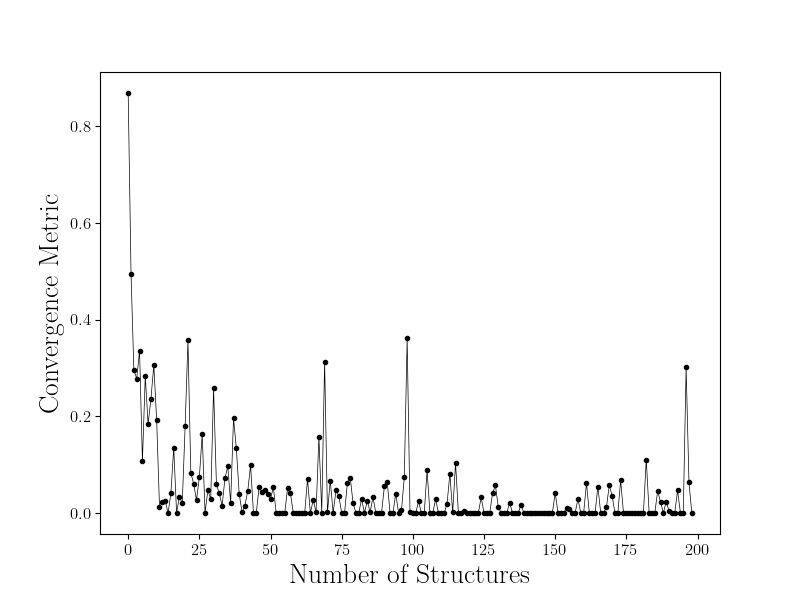

In [9]:
# plot convergence log plot as a function of the number of structures
# ax = plt.figure(figsize=(8, 6))
%matplotlib widget
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
power = 1.0 / 3.0
plt.plot(np.arange(len(convergence)), [ x**power for x in convergence], color="black", linestyle="-", marker='o', markersize=3, linewidth=0.5, label='Convergence')
# change colour of line to black


ax.set_xlabel('Number of Structures', fontsize=20)
ax.set_ylabel('Convergence Metric', fontsize=20)
# plt.title('Convergence of the Raffle Generator')
ax.set_yscale('linear')
plt.show()

# set x and y limits
ax.set_xlim(0, len(convergence)+1)
# ax.set_ylim(0, None)

# add y=0 line
ax.axhline(0, color='black', linestyle='--', linewidth=1.0)
# change colour of points and line to black
# plt.setp(ax.lines, color='black')

# add labels to y-axis to convert from cube root to original scale
def format_y_ticks(y, pos):
    return f"{y**(1.0/power):.2f}"
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(format_y_ticks)
ax.yaxis.set_major_formatter(formatter)

# set the legend font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
ax.legend(fontsize=16)

# add a window averaged line
window_size = 20
averaged = np.convolve([ x**power for x in convergence], np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size-1, len(convergence)), averaged, color='red', label='Window Averaged')
plt.legend()

# add a cumulative average line
cumulative_average = np.cumsum([ x**power for x in convergence]) / np.arange(1, len(convergence)+1)
plt.plot(np.arange(len(convergence)), cumulative_average, color='blue', label='Cumulative Average')
plt.legend()

plt.savefig('Si-Ge_convergence.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')